In [11]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
model = 'random_direction'
method = 'mean'

df_eval = pd.concat([
    pd.read_csv(f'evaluate/evaluate_{model}_{i}.csv')
    for i in range(3, 19)
])

In [13]:
df_eval.columns

Index(['velocity', 'towers', 'users', 'accuracy', 'accuracy_std', 'error',
       'error_std', 'recover_time', 'map_time', 'execution_time'],
      dtype='object')

In [14]:
len(df_eval)

2016

In [15]:
df_eval = getattr(df_eval.groupby(['velocity', 'towers', 'users']), method)().reset_index()

In [16]:
df_eval.velocity.unique()

array(['(0.01, 0.01)', '(0.01, 0.02)', '(0.02, 0.04)', '(0.04, 0.04)',
       '(0.04, 0.08)', '(0.08, 0.1)', '(0.1, 0.1)'], dtype=object)

# Accuracy and error analysis

In [17]:
def plot_heatmap(vel_restriction, metric='accuracy', ax=None, vmin=None, vmax=None, cbar=True, title=''):
    df = df_eval[df_eval.velocity == vel_restriction]
    
    n_tower_values = len(df.towers.unique())
    n_users_values = len(df.users.unique())

    sns.heatmap(
        df[metric].as_matrix().reshape((n_tower_values, n_users_values)),
        ax=ax,
        xticklabels=df['users'].unique(),
        yticklabels=df['towers'].unique(),
        vmax=vmax,
        vmin=vmin,
        cbar=cbar,
        square=True,
        fmt=".2f",
        annot=True,
    )
    
    ax.set(xlabel='# Users', ylabel='# Towers')
    ax.set_title(title, pad=12)

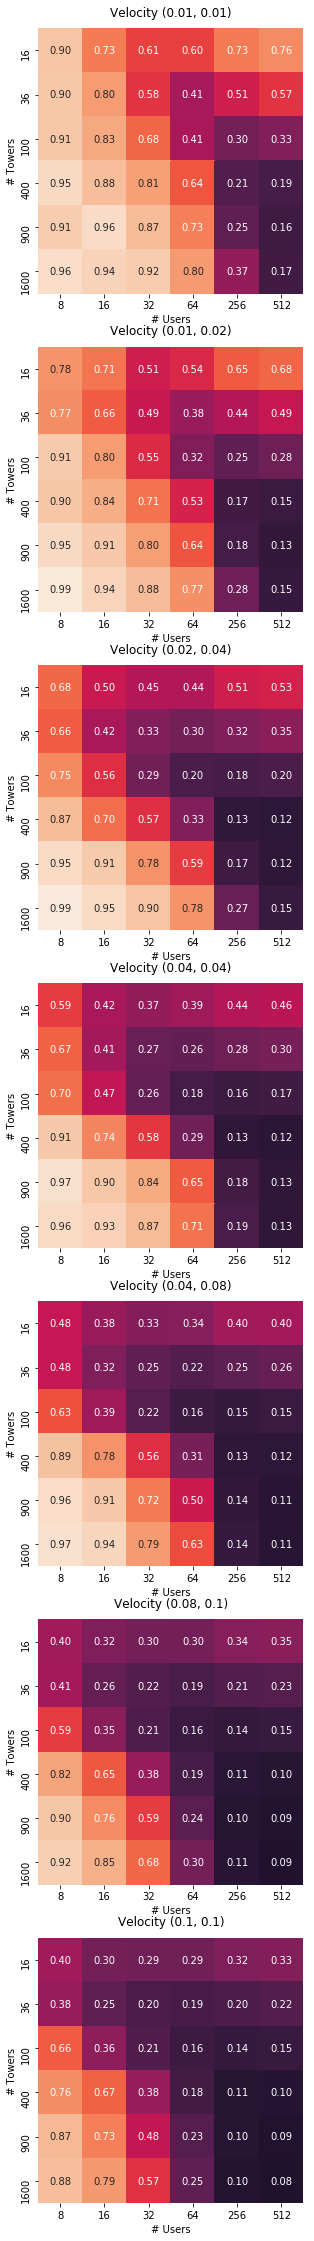

In [21]:
n_velocity_values = len(df_eval.velocity.unique())
fig, axes = plt.subplots(nrows=n_velocity_values, ncols=1, figsize=(8, 40))

for i, vel in enumerate(df_eval.velocity.unique()):
    plot_heatmap(
        vel_restriction=vel,
        title=f'Velocity {vel}',
        metric='accuracy',
        ax=axes[i],
        vmin=0,
        vmax=1,
        cbar=False)

plt.savefig(f'./accuracy_{model}.png', dpi=300)

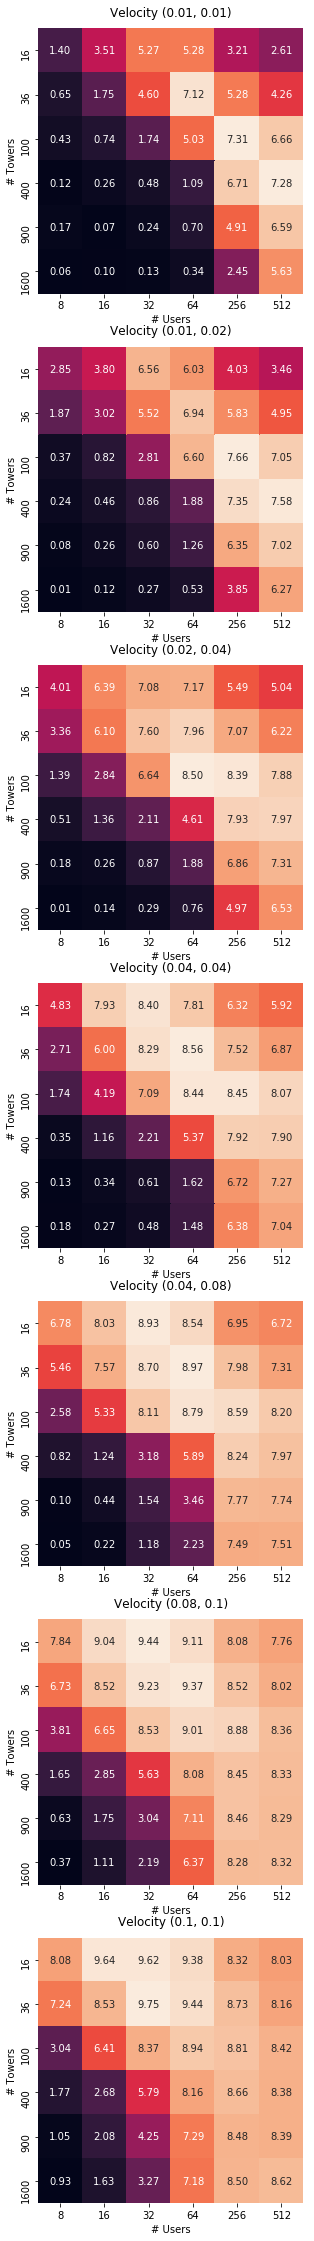

In [22]:
n_velocity_values = len(df_eval.velocity.unique())
fig, axes = plt.subplots(nrows=n_velocity_values, ncols=1, figsize=(8, 40))

for i, vel in enumerate(df_eval.velocity.unique()):
    plot_heatmap(vel_restriction=vel, metric='error', ax=axes[i], title=f'Velocity {vel}', cbar=False)

plt.savefig(f'./error_{model}.png', dpi=300)

# Execution time analysis

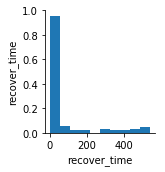

In [10]:
sns.pairplot(df_eval[['velocity', 'recover_time']])